In [2]:
using Flux, Flux.Data, Flux.Optimise
using Statistics, Random
using DataFrames
using CSV
using Dates
using LinearAlgebra

mutable struct GradientQLearning  
    A # action space (assumes 1:nactions) 
    y # discount 
    Q # action value function 
    gradientQ #gradient of action value function
    theta # action value function parameter
    alpha # learning rate 
end 

#create our action space

# our action space is 49 6-vectors
numActions = 49
pos = zeros(7,3)
ori = zeros(7,3)
actionSpace = zeros(numActions, 6)

pos_delta = 0.00005
ori_delta = .0002

count = 1;
for i = 1:3
    pos[count, i] = pos_delta
    count+= 1
    pos[count, i] = -pos_delta
    count+= 1
end
# reset count
count = 1;
for i = 1:3
    ori[count, i] = ori_delta
    count+= 1
    ori[count, i] = -ori_delta
    count+= 1
end

# reset count
count = 1;
for j = 1:length(pos[:,1])
    for k = 1:length(pos[:,1])
        actionSpace[count, :] = vcat(pos[j, :], ori[k, :])
        count += 1
    end
end

# put all actions into a dictionary 
# map each action vector to an integer for indexing 
# which set of parameters we are training

actionDict = Dict() 
for l = 1:length(actionSpace[:,1])
    actionDict[actionSpace[l, :]] = l
end


In [3]:
# create our basis functions for our linear approximation of Q

numStateComp = 18

function beta(s, a)
    idx = actionDict[a]
    basis = zeros(1, numActions*numStateComp+1)
    basis[numActions*numStateComp+1] = 1
    
    s = [s[1], s[2], s[3], s[4], s[5], s[6], s[7], s[8], s[9], 
    s[1]^2, s[2]^2, s[3]^2, s[4]^2, s[5]^2, s[6]^2, s[7]^2, s[8]^2, s[9]^2]
    
    basis[idx*numStateComp-numStateComp+1:idx*numStateComp] = s
    return basis
end

Q(theta, s, a) = dot(theta, beta(s, a))
    
gradientQ(theta, s, a) = beta(s, a)

scale_gradient(gradient, L2_max) = min(L2_max/norm(gradient), 1)*gradient

function update!(model::GradientQLearning, s, a, r, s′) 
    A, y, Q, theta, alpha = model.A, model.y, model.Q, model.theta, model.alpha 
    u = maximum(Q(theta, s′, a′) for a′ in eachrow(A))
    delta = (r + y*u - Q(theta, s, a))*model.gradientQ(theta, s, a)
    theta[:] += (alpha*scale_gradient(delta,1))[:]
    return model 
end

update! (generic function with 1 method)

In [4]:
# define our parameters and initialize our thetas

theta = zeros(1, numActions*numStateComp+1)
theta[numActions*numStateComp+1] = 1
sub_theta = [10000, 10000, 10000, 10000, 10000, 10000, 1, 1, 1, 
    100, 100, 100, 100, 100, 100, .1, .1, .1]
for i = 1:numActions
    theta[i*numStateComp-numStateComp+1: i*numStateComp] = sub_theta
end

stateComponents = 9
actionComponents = 6
forceComponents = 3

learning_rate = 0.5
discount = 0.95

model = GradientQLearning(actionSpace, discount, Q, gradientQ, theta, learning_rate)

numOfTraj = 1
total_iterations = 1

t1 = now();

for i in 1:total_iterations
    for k in 1:numOfTraj
        trajectory = string("output", k, ".csv")
        data = CSV.read(trajectory, DataFrame)
        for row in eachrow(data) 
                row = collect(row)
                s = row[1:stateComponents]
                a = row[stateComponents + 1: stateComponents + actionComponents]
                r = row[stateComponents + actionComponents + 1]
                s′ = row[stateComponents + actionComponents + 2: end]
                model = update!(model, s, a, r, s′)
        end 
    end
end

t2 = now();

In [5]:
t2 - t1

4830 milliseconds

In [6]:
theta[:]

883-element Vector{Float64}:
 10000.000004779708
  9999.999901400588
 10000.002067555204
  9999.990366240647
  9999.998289660647
  9999.998067644889
     1.0040363266494525
     1.00862539171997
     1.3900666076539994
   100.00000002244357
   100.00000023617798
   100.00010296895464
   100.00415952855253
     ⋮
   -27.41586871381081
    -7.787559204970774
    99.98005685197646
    99.70557710596067
    99.1201944189559
    96.08016864718577
    90.68051075333521
    65.17460120822723
    10.470682350154807
     6.865360911225706
    24.49161904926667
  -119.98987878179588

In [345]:
println(a′ for a′ in eachrow(actionSpace))

Base.Generator{RowSlices{Matrix{Float64}, Tuple{Base.OneTo{Int64}}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}, typeof(identity)}(identity, SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}[[5.0e-5, 0.0, 0.0, 0.0002, 0.0, 0.0], [5.0e-5, 0.0, 0.0, -0.0002, 0.0, 0.0], [5.0e-5, 0.0, 0.0, 0.0, 0.0002, 0.0], [5.0e-5, 0.0, 0.0, 0.0, -0.0002, 0.0], [5.0e-5, 0.0, 0.0, 0.0, 0.0, 0.0002], [5.0e-5, 0.0, 0.0, 0.0, 0.0, -0.0002], [5.0e-5, 0.0, 0.0, 0.0, 0.0, 0.0], [-5.0e-5, 0.0, 0.0, 0.0002, 0.0, 0.0], [-5.0e-5, 0.0, 0.0, -0.0002, 0.0, 0.0], [-5.0e-5, 0.0, 0.0, 0.0, 0.0002, 0.0], [-5.0e-5, 0.0, 0.0, 0.0, -0.0002, 0.0], [-5.0e-5, 0.0, 0.0, 0.0, 0.0, 0.0002], [-5.0e-5, 0.0, 0.0, 0.0, 0.0, -0.0002], [-5.0e-5, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 5.0e-5, 0.0, 0.0002, 0.0, 0.0], [0.0, 5.0e-5, 0.0, -0.0002, 0.0, 0.0], [0.0, 5.0e-5, 0.0, 0.0, 0.0002, 0.0], [0.0, 5.0e-5, 0.0, 0.0, -0.0002, 0.0], [0.0, 5.0e-5, 0.0, 0.0, 0.0, 0.

In [50]:
# read thetas from dense 3500
theta_3500 = CSV.read("theta_3500_Dense.csv", DataFrame)
theta_3500 = collect(theta_3500[:,1])

# find Q for y range -.05 to 0.05 and z range from 0.0002 to 0.07
# fix forces to be low at 1, 1, 1
# fix xerr to be low at 0.0002

xerr = 0.0002
r = 0.02
f = 1
Q_a_3500_table = zeros(400, 9) # Q, yerr, zerr, action(6)

yerr = range(-0.05, stop=0.05, length = 20)
zerr = range(0.0002, stop = 0.07, length = 20)
count = 1;
for i = 1:length(yerr)
    for j = 1:length(zerr)
        s = [xerr, yerr[i], zerr[j], r, r, r, f, f, f]
        Qmax, idx = findmax(Q(theta_3500, s, a′) for a′ in eachrow(actionSpace))
            
        #Qmax = maximum(Q(theta_3500, s, a′) for a′ in eachrow(actionSpace))
        #idx = argmax(Q(theta_3500, s, a′) for a′ in eachrow(actionSpace))
        
        Q_a_3500_table[count, 1] = Qmax
        Q_a_3500_table[count, 2] = yerr[i]
        Q_a_3500_table[count, 3] = zerr[j]
        Q_a_3500_table[count, 4:end] = actionSpace[idx, :]
        count += 1
    end
end
Q_a_3500_table

400×9 Matrix{Float64}:
      1.17101e5  -0.05  0.0002      0.0  -5.0e-5  0.0  0.0002  0.0  0.0
      1.17105e5  -0.05  0.00387368  0.0  -5.0e-5  0.0  0.0002  0.0  0.0
      1.1711e5   -0.05  0.00754737  0.0  -5.0e-5  0.0  0.0002  0.0  0.0
 117114.0        -0.05  0.0112211   0.0  -5.0e-5  0.0  0.0002  0.0  0.0
      1.17119e5  -0.05  0.0148947   0.0  -5.0e-5  0.0  0.0002  0.0  0.0
 117123.0        -0.05  0.0185684   0.0  -5.0e-5  0.0  0.0002  0.0  0.0
      1.17127e5  -0.05  0.0222421   0.0  -5.0e-5  0.0  0.0002  0.0  0.0
 117132.0        -0.05  0.0259158   0.0  -5.0e-5  0.0  0.0002  0.0  0.0
      1.17136e5  -0.05  0.0295895   0.0  -5.0e-5  0.0  0.0002  0.0  0.0
 117141.0        -0.05  0.0332632   0.0  -5.0e-5  0.0  0.0002  0.0  0.0
      1.17145e5  -0.05  0.0369368   0.0  -5.0e-5  0.0  0.0002  0.0  0.0
 117150.0        -0.05  0.0406105   0.0  -5.0e-5  0.0  0.0002  0.0  0.0
      1.17155e5  -0.05  0.0442842   0.0  -5.0e-5  0.0  0.0002  0.0  0.0
      ⋮                                  

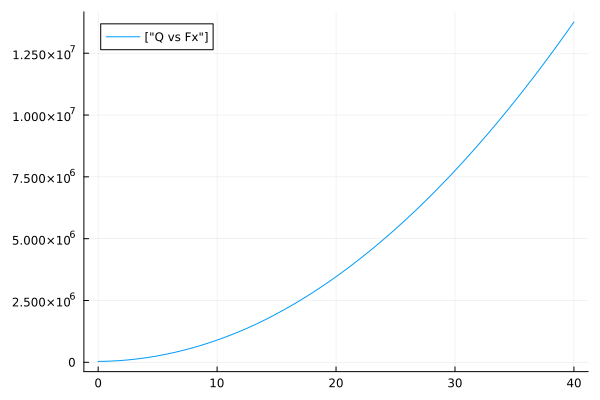

In [66]:
using Plots

# read thetas from dense 3500
theta_3500 = CSV.read("theta_3500_Dense.csv", DataFrame)
theta_3500 = collect(theta_3500[:,1])

# find Q for y range -.05 to 0.05 and z range from 0.0002 to 0.07
# fix forces to be low at 1, 1, 1
# fix xerr to be low at 0.0002

xerr = 0.0002
yerr = -0.01
zerr = 0.05
r = 0.001

Q_f_3500_table = zeros(50, 2) # Q, fz

f = 0.01
fz = range(0, stop=40, length = 50)

for i = 1:length(fz)
    s = [xerr, yerr, zerr, r, r, r, f, f, fz[i]]
    Qmax, idx = findmax(Q(theta_3500, s, a′) for a′ in eachrow(actionSpace))

    #Qmax = maximum(Q(theta_3500, s, a′) for a′ in eachrow(actionSpace))
    #idx = argmax(Q(theta_3500, s, a′) for a′ in eachrow(actionSpace))

    Q_f_3500_table[i, 1] = Qmax
    Q_f_3500_table[i, 2] = fz[i]
end
Q_f_3500_table
plot(Q_f_3500_table[:, 2], Q_f_3500_table[:,1], label=["Q vs Fx"])